<a href="https://colab.research.google.com/github/kartik727/ml-projects/blob/master/naive-bayes/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import os

## Setting up

In [2]:
config = {
    'data' : {
        'train' : 'https://raw.githubusercontent.com/kartik727/ml-projects/master/naive-bayes/data/Corona_NLP_train.csv',
        'test' : 'https://raw.githubusercontent.com/kartik727/ml-projects/master/naive-bayes/data/Corona_NLP_test.csv'
    },
    'training' : {
        'binary_classification' : False,
        'lowest_pos_class' : 2,
        'word_count_threshold' : 10
    }
}

In [3]:
# Downloading data
os.system(f'curl -o train.csv {config["data"]["train"]}')
os.system(f'curl -o test.csv {config["data"]["test"]}')

0

In [4]:
train_df = pd.read_csv('train.csv', encoding='latin-1')

## Text pre-processing

The `preprocess` function will convert a sentence into a form that can be understood by our Naive Bayes classifier.

In [5]:
def preprocess(sentence:str)->str:
    # Remove non-ascii characters
    sentence = ''.join([i if ord(i) < 128 else '' for i in sentence])

    # Remove @usernames
    sentence = re.sub('@[^\s]+ ?','',sentence)

    # Remove URLs
    sentence = re. sub(r'\S*https?:\S*', '', sentence)

    # Remove punctuations
    sentence = re.sub('[^\w\s]', ' ', sentence)
    sentence = re.sub('_', ' ', sentence)

    # Remove \n and \r
    sentence = re.sub('\\r', '', sentence)
    sentence = re.sub('\\n', '', sentence)

    # Remove numbers
    sentence = re.sub('[0-9]+', '', sentence)

    # Replace multiple spaces with single space
    sentence = re.sub(' +', ' ', sentence)

    # Convert to lowercase
    sentence = sentence.lower()

    return sentence.rstrip()

In [6]:
train_df['text'] = train_df['OriginalTweet'].apply(preprocess)

## Converting labels into classes
The classes are mentioned in text form in the data. We want to convert them into numerical format for our model. Optionally, we also want to turn the problem into binary classification.

In [7]:
classes = {
    'Extremely Negative' : 0,
    'Negative' : 1,
    'Neutral' : 2,
    'Positive' : 3,
    'Extremely Positive' : 4,
}

num_classes = len(classes)
train_df['class'] = train_df['Sentiment'].replace(classes)

# Optinally converting multi-class into binary classification
if config['training']['binary_classification']:
    min_pos = config['training']['lowest_pos_class']
    train_df['class'] = train_df['class'].apply(lambda x: 0 if x<min_pos else 1)
    num_classes = 2

In [8]:
# Only keeping the preprocessed data and the class labels 
train_df = train_df[['text', 'class']]

In [9]:
train_df.head()

,text,class
0,and and,2
1,advice talk to your neighbours family to excha...,3
2,coronavirus australia woolworths to give elder...,3
3,my food stock is not the only one which is emp...,3
4,me ready to go at supermarket during the covid...,0


## Create Vocabulary
The vocabulary will hold all the words known to our model and the count of how many times they occurred in the training data.

In [10]:
Vocab = dict()
for idx, row in train_df.iterrows():
    sentence = row['text']
    for word in sentence.split(' '):
        Vocab[word] = Vocab.get(word, 0) + 1

In [11]:
# Removing uncommon words
num_threshold = config['training']['word_count_threshold']
words = list(Vocab.keys())
for word in words:
    if Vocab[word] < num_threshold:
        del Vocab[word]

In [12]:
# Total number of words in our vocabulary
vocab_words = len(Vocab)

## Calculating class-wise probabilities
Now we can calculate the class priors and conditional probabilities of words given a class.

We will also create two mappings `idx_to_word` and `word_to_index` that will allow us to map words to their indices in the word probabilites table.

In [13]:
# Array of length (num_classes) containing class priors
cls_probs = np.zeros((num_classes,))

# Matrix of size (vocab_words x num_classes) containing conditional word probabilities
wrd_probs = np.ones((vocab_words, num_classes)) 

In [14]:
idx_to_word = np.empty((vocab_words,), dtype=object)
word_to_idx = {}

for i, word in enumerate(Vocab):
    idx_to_word[i] = word
    word_to_idx[word] = i

In [15]:
# Counting word occurrences per class
for idx, row in train_df.iterrows():
    sentence = row['text']
    text_class = row['class']
    cls_probs[text_class] += 1
    for word in sentence.split(' '):
        if word in Vocab:
            idx = word_to_idx[word]
            wrd_probs[idx, text_class] += 1

In [16]:
# Dividing word occurrences by total occurrences per class to get probabilities
cls_word_sums = wrd_probs.sum(axis=0)
for row in range(vocab_words):
    for col in range(num_classes):
        wrd_probs[row, col] = wrd_probs[row, col] / cls_word_sums[col]

## Inference
To predict a class, we will calculate the posterior probabilities for each class using the likelihood and prior probabilities from the tables that we computed. Then, the class with the highest posterior probability will become our prediction.

For numerical stability, we will compare the sum of log probabilites instead of product of probabilities.

In [17]:
def log_prob(sentence:str, cls:int)->float:
    '''Calculates the log posterior probability for a given sentence and class'''
    
    words = preprocess(sentence).split(' ')
    log_prob = 0.

    # Calculating log likelihood
    for word in words:
        if word in Vocab:
            word_idx = word_to_idx[word]
            word_prob = wrd_probs[word_idx, cls]
            log_prob += math.log(word_prob)
    
    # Adding log prior
    log_prob += math.log(cls_probs[cls])

    return log_prob

In [18]:
def pred_class(sentence:str)->int:
    '''Predicts the class of a given sentence using the Naive Bayes method'''

    log_probs = np.empty((num_classes,))
    for cls in range(num_classes):
        log_probs[cls] = log_prob(sentence, cls)
    
    # Predicting the class with the maximum log posterior
    pred = np.argmax(log_probs)
    return pred

## Training data performance

In [19]:
# Confusion Matrix
def show_confusion_matrix(df:pd.DataFrame)->None:
    conf_matrix = confusion_matrix(df['class'], df['pred'])
    df_cm = pd.DataFrame(conf_matrix)
    fig = plt.figure(figsize = (10,7))
    ax = sns.heatmap(df_cm, annot=True)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    fig.show()

In [20]:
def print_perf_metrics(df:pd.DataFrame)->None:
    average = 'binary' if num_classes==2 else 'macro'
    precision = precision_score(df['class'], df['pred'], average=average)
    recall = recall_score(df['class'], df['pred'], average=average)
    f1 = f1_score(df['class'], df['pred'], average=average)
    accuracy = accuracy_score(df['class'], df['pred'])

    print(f'Accuracy    : {accuracy*100:.3f}%')
    print(f'Precision   : {precision*100:.3f}%')
    print(f'Recall      : {recall*100:.3f}%')
    print(f'F1 Score    : {f1*100:.3f}%')

In [21]:
# Computing the predictions using the `pred_class` function
train_df['pred'] = train_df['text'].apply(pred_class)

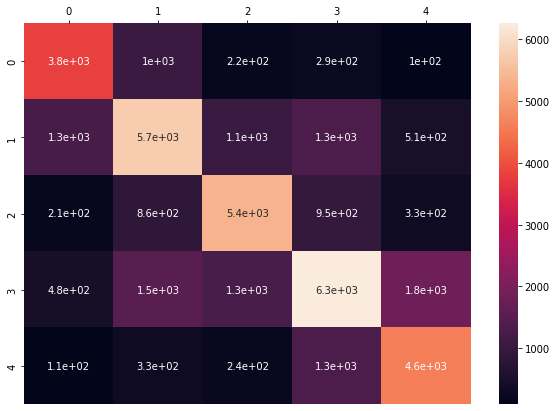

In [22]:
show_confusion_matrix(train_df)

In [23]:
print_perf_metrics(train_df)

Accuracy    : 62.711%
Precision   : 62.964%
Recall      : 64.353%
F1 Score    : 63.545%


## Test data performance

In [24]:
# Loading and preprocessing test data
test_df = pd.read_csv('test.csv', encoding='latin-1')
test_df['text'] = test_df['OriginalTweet'].apply(preprocess)

test_df['class'] = test_df['Sentiment'].replace(classes)
if config['training']['binary_classification']:
    test_df['class'] = test_df['class'].apply(lambda x: 0 if x<min_pos else 1)

test_df = test_df[['text', 'class']]

In [25]:
test_df['pred'] = test_df['text'].apply(pred_class)

In [26]:
test_df.head()

,text,class,pred
0,trending new yorkers encounter empty supermark...,0,2
1,when i couldn t find hand sanitizer at fred me...,3,3
2,find out how you can protect yourself and love...,4,4
3,panic buying hits newyork city as anxious sho...,1,1
4,toiletpaper dunnypaper coronavirus coronaviru...,2,2


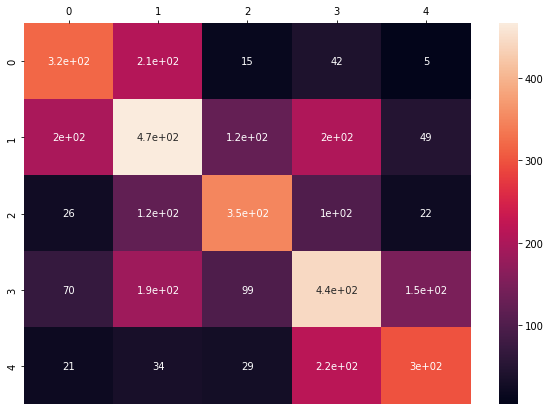

In [27]:
show_confusion_matrix(test_df)

In [28]:
print_perf_metrics(test_df)

Accuracy    : 49.421%
Precision   : 50.793%
Recall      : 50.379%
F1 Score    : 50.516%


## Generating new sentences
Since NB learns the conditional probabilities of the words, we can generate new sentences using those probabilities. The generated sentences will likely be gramatically incorrect since our model is a unigram model and has no notion of word orders.

In [29]:
num_words = 8
class_num = 0   # 0 or 1 for binary. 0-4 for multi-class

# Indices of randomly selected words from our vocabulary based on the learned probabilities
gen_idxs = np.random.choice(vocab_words, size=(num_words,), p=wrd_probs[:, class_num])

# Converting indices into words
gen_words = np.empty_like(gen_idxs, dtype=object)
for i in range(len(gen_words)):
    gen_words[i] = idx_to_word[gen_idxs[i]]

# Concatenating words into sentence
gen_sentence = ' '.join(gen_words)

print(gen_sentence)

once panic but o of bad full to
